In [22]:
# Imports
%matplotlib inline
from IPython.display import Image
from IPython.display import HTML, display
from ipywidgets import interact, fixed

from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata
from sklearn.manifold import Isomap, MDS
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_circles
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go
from jupyter_plotly_dash import JupyterDash
import numpy as np
import pandas as pd

from scipy.special import expit
import scipy.spatial.distance as spatial_distance
from scipy.stats import beta, norm

import pathlib

import warnings
warnings.filterwarnings("ignore")

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets as vision_datasets
from torchvision import transforms
import os
dirpath = os.getcwd()

In [8]:
# Utils 1st section
def plot_train_test(df):
    trace0 = go.Scatter(
        x=df["x_train"][:80],
        y=df["y_train"][:80],
        name='Training Data',
        mode='markers',
        opacity=0.3,
    )
    trace1 = go.Scatter(
        x=df["x_test"][:20],
        y=df["y_test"][:20],
        name='Test Data',
        mode='markers',
        opacity=0.3,    
    )
    trace2 = go.Scatter(
        x=df["x_train"][:80],
        y=df["pred_train"][:80],
        name='Prediction',
        mode='markers',
    )
    data = [trace0, trace1, trace2]
    return  go.Figure(data=data)


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)



def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [9]:
# Utils 3rd section
def batch_multiply(float_or_vector, tensor):
    if isinstance(float_or_vector, torch.Tensor):
        assert len(float_or_vector) == len(tensor)
        tensor = _batch_multiply_tensor_by_vector(float_or_vector, tensor)
    elif isinstance(float_or_vector, float):
        tensor *= float_or_vector
    else:
        raise TypeError("Value has to be float or torch.Tensor")
    return tensor


def _batch_multiply_tensor_by_vector(vector, batch_tensor):
    return (
        batch_tensor.transpose(0, -1) * vector).transpose(0, -1).contiguous()


def batch_clamp(float_or_vector, tensor):
    if isinstance(float_or_vector, torch.Tensor):
        assert len(float_or_vector) == len(tensor)
        tensor = _batch_clamp_tensor_by_vector(float_or_vector, tensor)
        return tensor
    elif isinstance(float_or_vector, float):
        tensor = torch.clamp(tensor, -float_or_vector, float_or_vector)
    else:
        raise TypeError("Value has to be float or torch.Tensor")
    return tensor


def _batch_clamp_tensor_by_vector(vector, batch_tensor):
    return torch.min(
        torch.max(batch_tensor.transpose(0, -1), -vector), vector
    ).transpose(0, -1).contiguous()


def get_data():
    train_loader = torch.utils.data.DataLoader(
        vision_datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        vision_datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, test_loader

def save(model, savepath):
    torch.save(model.state_dict(), savepath)

def load_model(path, device):
    model = Net()
    model.load_state_dict(torch.load(path))
    model.to(device)
    return model

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().detach().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

# Adversarial Machine Learning - Theoretical and Practical Perspectives
### Tutorial @WIFS 2019, Delft


<br><br><br>
## Alex Serban
<br>

#### Radboud University, Nijmegen
#### Software Improvement Group, Amsterdam

# Abstract

This document supports the tutorial on adversarial examples presented at [WIFS 2019](https://wifs2019.tudelft.nl/?q=node/12) and it is an interactive extension of a [larger survey](https://arxiv.org/abs/1810.01185) made publicly available before the tutorial. Since the event is focused on security and expects participants with various backgrounds in the field, the first part of the tutorial is dedicated to an introduction to machine learning, describing the general setting and the most important assumptions. In order to maintain focus on security issues, we use examples from supervised classification - a branch of machine learning - although the information contained in this notebook can easily be extended to regression, unsupervised classification or reinforcement learning.
Whenever possible. pointers and references to these fields are given.

The second part presents a taxonomy on security of machine learning and gives references to relevant works for each attack type.

The third  (and last) part of the tutorial dives into adversarial inputs, a type of attack at test (inference) time.

Transcript notes will soon be added.

# Logistics and Outline

* all materials are available at: https://404.hml
* the practical assignment can be found online at: https://tinyurl.com/uqtu3xx

<br><br>

<div class="grey"> Part I: Introduction to Machine Learning </div>
<div>
    
- General goals and Training a model
- The No Free Lunch Theorem, The curse of dimensionality
- Assumptions behind ML algorithms
- Neural networks and Universal function approximations
</div>
<br>

<div class="grey"> Part II: Security of Machine Learning </div>
<div>
    
- The Machine Learning Pipeline
- Types of Attacks
- Taxonomy of ML Attacks
</div>

<br>

<div class="grey"> Part III: Adversarial Examples </div>
<div>

- Historical considerations and definition
- Noise and Geometric Perturbations
- Hypotheses behind their existence
- Adversarial Transferability
- Defenses

</div>

In [18]:
###
#  Code to hide the code from presentations
###

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Part I - Introduction to Machine Learning

- General goals and Training a model
- The No Free Lunch Theorem, The curse of dimensionality
- Assumptions behind ML algorithms
- Neural networks and Universal function approximations

# Machine learning - textbook definition

## A computer program is said to learn from <span class="red"> experience E </span>  with respect to some class of <span class="red"> tasks T</span> and <span class="red"> performance measure P </span>, if its performance at tasks in T, as measured by P, improves with experiences E.  <small> [T. Mitchell, Machine Learning, 1997]</small>


<br>

# Ingredients:

*  Tasks = any functionality for which we do not have a specification e.g. translate speech to text, identify objects in images, etc.
*  Experiences =  data describing as accurate as possible the task e.g. audio recordings, text transcripts, labeled photos, etc.
*  Performance measures = a function which quantifies the error

<br>

# Recipe:

* Minimize the error function on the available data


# Other ingredients:

* a function to start with - we can not search for all possible mathemetical functions that can perform the task

# Running example

## Classify irises based on different petal properties



| Iris Setosa | Iris Versicolor| 
| :---: | :---: |
| ![alt](./figures/irises/iris_setosa.jpg) | ![alt](./figures/irises/iris_versicolor.jpg)|

# Ingredients

Following the definition by Mitchell we have to select the following ingredients:

* Task - classify irises
* Experiences - we will start with petal width for approx. 25 plants for each class, and a *label* for each example
* Performance measure - we will use the mean squared error (details will follow later) 

# More ingredients

* A family of functions - as mentioned earlier we can not search through all possible mathematical functions - we will start with the family of <span class="red">linear functions </span>


# Recipe 
* Minimize the loss function on data examples

# Formally

<br>


* classify irises is a function from the domain of petal width to the codomain of a class: 

<div class="centered">    $$ f : \mathbb{R} \mapsto \mathcal{C} $$ </div>

* $$ m $$ observations $$(x_1, y_1), (x_2, y_2) \dots, (x_n, y_n)$$ sampled from a distribution $$ \mathcal{D} $$ defined over a space $$\mathcal{Z} = \mathcal{X} \times 
\mathcal{Y}$$,

where $$ x_n $$ is the petal width and $$ y_n $$ is the desired *outcome* or label,


* a loss function,  $$ \mathcal{J} : \mathcal{Y} \times \mathcal{Y} $$:

<div class="centered"> $$ \mathcal{J} = \frac{1}{n} \sum_{i}^{n} (f(x_n) - y_n )^2 $$ </div>


the goal is to find a rule $$ f(\cdot) $$ that minimizes $\mathcal{J}(\cdot)$ on all samples from $\mathcal{D}$.


# Training

* we decided earlier that $$ f(\cdot) $$ is a linear function of the form:

<div class="centered"> $$ f = W^Tx $$ </div>

* the optimization can be done with various algorithms e.g. L-BFGS, gradient descent, etc.

* after training:

<div class="centered"> $$ f = argmin \quad \frac{1}{n} \sum_{i}^{n} (W^Tx_n - y_n )^2 $$ </div>




# Visualizing a sample of the dataset

In [10]:
# Display the petal width
iris_px = px.data.iris()
fig = px.scatter(iris_px[:80], y="species_id", x="petal_width", color="species")
fig.update_layout(title="Iris Dataset, petal width")
fig.show()

# Training the linear model described earlier

In [11]:
iris = datasets.load_iris()
X = iris.data[:100]  # we only take the last feature.
y = iris.target[:100]
X = X[:, np.newaxis, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
train_preds = regr.predict(X_train)
test_pres = regr.predict(X_test)

X_linspace = np.linspace(1, 5, 300)

trace0 = go.Scatter(
    x=X_train.reshape([-1]),
    y=y_train,
    name='Training Data',
    mode='markers',
    opacity=0.3,
)
trace1 = go.Scatter(
    x=X_test.reshape([-1]),
    y=y_test,
    name='Test Data',
    mode='markers',
    opacity=0.3,    
)
trace2 = go.Scatter(
    x=X_linspace,
    y=regr.coef_ * X_linspace + regr.intercept_,
    name='Linear Regression',
    mode='lines',
)
data = [trace0, trace1, trace2]
fig = go.Figure(data=data)
fig.update_layout(
    title="Linear Regression Iris, 1 feature",
    xaxis_title="petal_width",
    yaxis_title="species_id"
)
fig.show()

# Disadvantages:
* our function interpolates between the datapoints, instead of separating them
* there is no threshold where we switch from one class to another

# Solutions? 

* We can select a different family of functions

* For example, a function some that look more like an sinus curve (logistic):

<img src="./figures/part1/logistic.png" alt="drawing" class="centered" width="600"/>

<div class="centered">  $$ f = \frac{1}{1 + e^{-W^Tx}} $$ </div>

* since the outcome is categorical we can also use a different loss function, which measures the difference between class distributions:

<div class="centered"> $$ \mathcal{L} = -{(y\log(f(\cdot)) + (1 - y)\log(1 - f(\cdot)))} $$

# Training the classifier with logistic regression

In [12]:
# Logistic
log = linear_model.LogisticRegression(solver="lbfgs")

log.fit(X_train, y_train)
train_preds = log.predict(X_train)
test_pres = log.predict(X_test)


loss = expit(X_linspace * log.coef_ + log.intercept_).ravel()

trace0 = go.Scatter(
    x=X_train.reshape([-1]),
    y=y_train,
    name='Training Data',
    mode='markers',
    opacity=0.3,
)
trace1 = go.Scatter(
    x=X_test.reshape([-1]),
    y=y_test,
    name='Test Data',
    mode='markers',
    opacity=0.3,    
)
trace2 = go.Scatter(
    x=X_linspace,
    y=loss,
    name='Logistic Regression',
    mode='lines',
)

data = [trace0, trace1, trace2]
fig = go.Figure(data=data)
fig.update_layout(
    title="Logistic Regression Iris, 1 feature",
    xaxis_title="petal_width",
    yaxis_title="species_id"
)
fig.show()

- we observe that the logistic function and the cross entropy loss are a better fit for our problem.

# Take aways - The initial family of functions and No Free Lunch

* The initial family of functions we choose is very important (this is also called *inductive bias*)

<br>

* a result from optimization tells us that the computational cost for finding a solution averaged over all problems in one class is the same for any solution

<br>

* this means we can not have a function that can solve all possible tasks - 
choosing a good initial family of functions is important


<br>

* The choice for the error function is also important, although the commonly used loss functions are cross-entropy in classification and mean squared error in regression

# We can already classify machine learning based on the data used during training and the expected outcome in


## Supervised learning - the outcome is known before and used during training
* classification - the outcome is categorical, e.g. $$ y \in {-1, +1} $$
* regression - the outcome is numerical, e.g. $$ y \in  \mathbb{R} $$ 


## Unsupervised learning - the outcome is not known or used in training - the algorithms learn to discover patterns without pre-defined labels
* Examples: Clustering, Dimensionality reduction


## Reinforcement learning - in reinforcement learning an agent interacts with the environment and receives a reward after each interaction. The  goal is to discover the actions that maximize the reward (e.g. winning a  game).

# An overview of ML branches


<br> <br> 

<img src="./figures/part1/ml.png" alt="drawing" class="centered" width="1000"/>

<br>

Although today we will focus on supervised classification, most of the security issues we mention apply to other algorithms too.


# Moving on


* we can use more data; for example, adding petal length to the training set

In [8]:
iris = datasets.load_iris()
X = iris.data[:100, 2:]  # we only take the last feature.
y = iris.target[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
train_preds = regr.predict(X_train)
test_pres = regr.predict(X_test)

X_linspace = np.linspace(1, 5, 300)

trace0 = go.Scatter3d(
    x=X_train[:, 0],
    y=y_train,
    z=X_train[:, 1],
    name='Training Data',
    mode='markers',
    opacity=0.3,
)
trace1 = go.Scatter3d(
    x=X_test[:, 0],
    y=y_test,
    z=X_test[:, 1],    
    name='Test Data',
    mode='markers',
    opacity=0.3,    
)

data = [trace0, trace1]
fig = go.Figure(data=data)

fig.update_layout(
                    title="Iris dataset, petal width and length",
                    scene = dict(
                    xaxis_title='petal_width',
                    yaxis_title='species_id',
                    zaxis_title='petal_length'),
)

fig.show()

# And try the same procedures

In [13]:
iris = datasets.load_iris()
X = iris.data[:100, 2:]  # we only take the last feature.
y = iris.target[:100]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
train_preds = regr.predict(X_train)
test_pres = regr.predict(X_test)

X_linspace = np.linspace(1, 5, 300)

trace0 = go.Scatter3d(
    x=X_train[:, 0],
    y=y_train,
    z=X_train[:, 1],
    name='Training Data',
    mode='markers',
    opacity=0.3,
)
trace1 = go.Scatter3d(
    x=X_test[:, 0],
    y=y_test,
    z=X_test[:, 1],    
    name='Test Data',
    mode='markers',
    opacity=0.3,    
)

trace2 = go.Scatter3d(
    x=X_linspace,
    y=regr.coef_[0] * X_linspace + regr.intercept_,
    z=regr.coef_[1] * X_linspace + regr.intercept_,
    name='Linear Regression',
    mode='lines',
)
data = [trace0, trace1, trace2]
fig = go.Figure(data=data)
fig.update_layout(title="Linear Regression Iris, 2 features",
                    scene = dict(
                    xaxis_title='petal_width',
                    yaxis_title='species_id',
                    zaxis_title='petal_length'),
)
fig.show()

* in this example we use again a linear function, which was not suitable for the task. 
* it is left as an exercise to implement logistic regression for this case

# However, ...

* The iris dataset is a toy example where we can distinguish between the classes

<br> 

# In reality:

* data is multi-dimensional - many real world problems have lots of variables 

For example, the iris dataset presented earlier has 4 variables: petal width, petal length, sepal width and sepal length


In contrast, an 8x8 image can be perceived as having 64 variables; one for each pixel

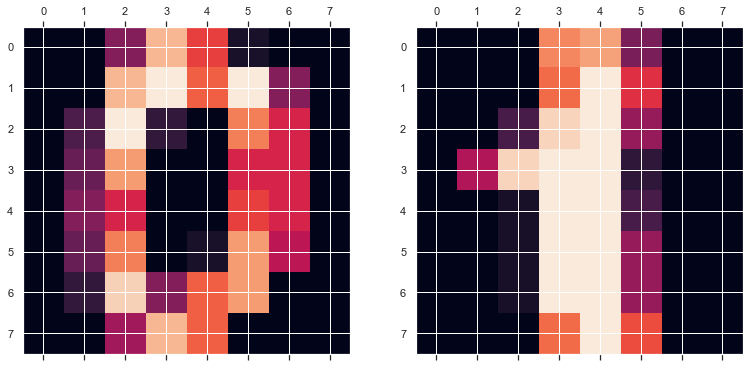

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.matshow(digits.images[0]) 

# plt.gray()
# plt.show()
ax2 = fig.add_subplot(2,2,2)
ax2.matshow(digits.images[1]) 
plt.gray()

set_size(10,10)
plt.show()

The number of possible distinct configuration of a set of variables increases exponentially with the set of variables - finding correlations between them and drawing discriminants between classes becomes harder (our linear models might not work in this space)

This is also called the *curse of dimensionality*.



<small>"To deal with a n-dimensional space, visualize a 3-D space and say 'n' to yourself very loudly. Everyone does it."[Geoffrey Hinton]</small>

# In reality:

* data is not always separable


For example projecting the MNIST dataset to a 2-D space, we get:

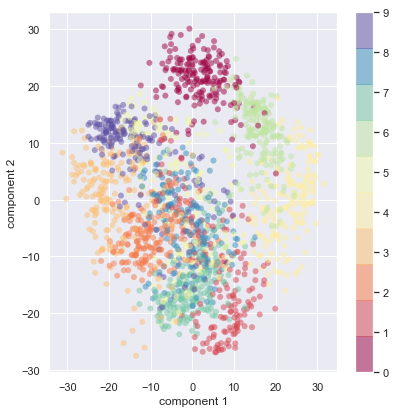

In [15]:
# project from 64 to 2 dimensions
pca = PCA(2)
projected = pca.fit_transform(digits.data)

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
set_size(5,5)
plt.colorbar();

We can see that it is not easy to draw a discriminant between classes in this space.

Online demos for other datasets: https://dash-gallery.plotly.host/dash-tsne/

# In reality:

* data is very distinct

<table class="centered" width="400">
<tr>
<td><img src='./figures/part1/apple_side.jpg'></td>
<td><img src='./figures/part1/apple_weird.png'></td>
</tr>
</table>

<table class="centered" width="400">
<tr>
<td><img src='./figures/part1/1.jpg'></td>
<td><img src='./figures/part1/1.1.jpg'></td>
<td><img src='./figures/part1/1.2.jpg'></td>
</tr>
</table>

* the training examples have to be informative about the testing examples

* although humans can distinguish between large variation of data, machine learning algorithms have troubles doing it.

# ML Assumptions 

<br>

Machine learning algorithms use two assumptions:

1. Training and testing data are drawn from the <span class="red"> same distribution </span> i.e. they are identically and independently distributed (the i.i.d assumption).


* for example, we can not train with irises with petals sampled from a normal distribution and test with trees with petals sampled from a beta distribution:

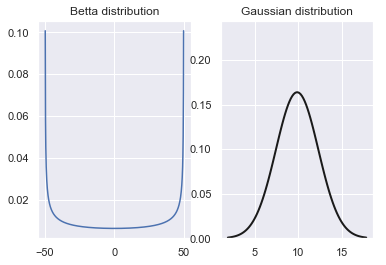

In [16]:
plt.figure()

a = 0.5
b = 0.5
x = np.arange (-50, 50, 0.1)
y = beta.pdf(x,a,b, scale=100, loc=-50)
plt.subplot(1,2,1)
plt.plot(x,y)
plt.title("Betta distribution")


# Generate some data for this demonstration.
data = norm.rvs(10.0, 2.5, size=500)
# Fit a normal distribution to the data:
mu, std = norm.fit(data)
plt.subplot(1,2,2)
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.0, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Gaussian distribution")

plt.show()

# As an exercise for the reader: you may sample from these distributions and try to train
# a classifier as earlier

This example is far fetched in order to make a point. 
It is enough to have a normal distribution with different mean and variance for testing.

# ML Assumptions 

<br>

Machine learning algorithms use two assumptions:

2. The data is not spread across all $$\mathbb{R}^n$$, but lies accross a collection of manifolds contaiining a small subset of points with interesting variations occuring along directions on the manifold (the manifold assumption)

For example, the 2D manifold of digit 1 from the MNIST dataset:

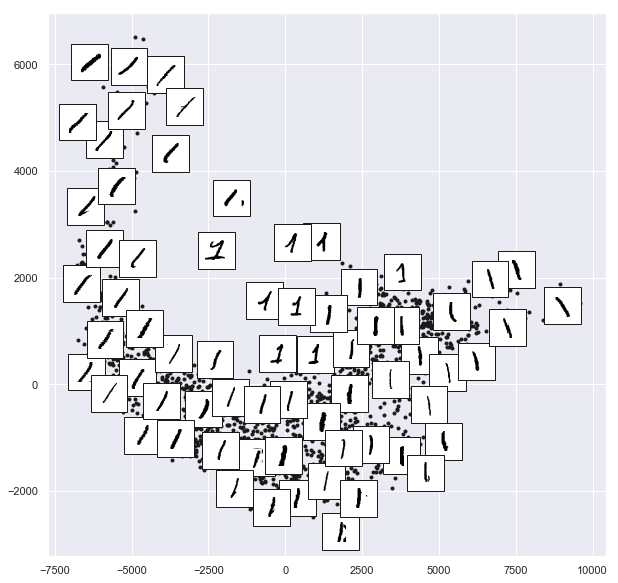

In [17]:
mnist = fetch_openml('mnist_784', version=1)

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == '1'][::4]
trg = np.array(mnist.data[mnist.target==1])
indx = np.where(trg == True)


fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')

plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

# Details on the Manifold Assumption

- the manifold is not dependent on variables, but on the distance between them

- this means we can map the manifold to different spaces keeping the distance between points consistent:

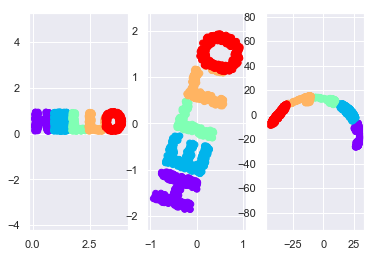

In [18]:
plt.figure()

def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.subplot(1,3,1)
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

D = pairwise_distances(X)
D.shape
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.subplot(1,3,2)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)
D = pairwise_distances(X)
# D.shape



model = MDS(n_components=2, random_state=2)
out = model.fit_transform(D)
plt.subplot(1,3,3)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

# This also means that if the data is not separable in a space:

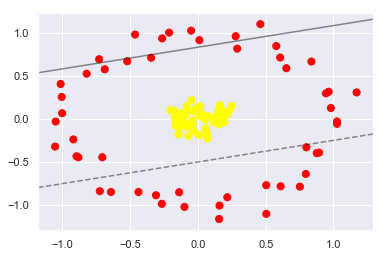

In [19]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

# We can map it to another space where we can separate it:

In [20]:
r = np.exp(-(X ** 2).sum(1))

dt = pd.DataFrame()
dt["x"] = X[:,0]
dt["y"] = X[:,1]
dt["r"] = r
dt["labels"] = 1

mask = dt['r'] <= 0.6
dt['labels'] = 1
dt.loc[mask, 'labels'] = 0

fig = px.scatter_3d(dt, x='x', y='y', z='r', color="labels")
fig.update_layout(showlegend=False)

fig.show()

# How can we draw complex discriminants between classes?

- for example, what if the decision boundary would look like this:

<img src="./figures/part1/universal/fx.png" alt="drawing" class="centered" width="600"/>

- we can try to find a polynomial function that approximates it and manually search through family of functions for each new problem.


# Approximations

- we can try to approximate it using a composition of functions:

<img src="./figures/part1/universal/approx2.png" alt="drawing" class="centered" width="600"/>

# Neural Networks
<img src="./figures/part1/universal/approx.png" alt="drawing" class="centered" width="700"/>

# Function Approximation in Higher Dimensions

<br><br>
<table class="centered"><tr><td><img src='./figures/part1/universal/multi1.png'></td><td><img src='./figures/part1/universal/multi2.png'></td><td><img src='./figures/part1/universal/multi3.png'></td></tr></table>

- we can apply the same compositional procedure to approximate functions with as many variables (dimensions) as we need

# Universal Function Approximators 

<br>

* it turns out that, in theory, we can approximate *any continuous function* with a neural network with one layer and many neurons 

* in practice, however, training a very wide neural network does not work very well

* we can instead build deeper networks (with many layers) which are less complicated to train


<small>Image cuortesy of: http://neuralnetworksanddeeplearning.com/chap4.html 


Follow the link for more interesting demo.
</small>

# Training Neural Networks - depth instead of width

- we can create a (deep) representation as a composition of many functions:

<img src="./figures/part1/forward_prop.png" alt="drawing" class="centered" width="1000"/>

- and back-propagate the error w.r.t. to each parameter in order to minimize it:

<img src="./figures/part1/back_prop.png" alt="drawing" class="centered" width="1000"/>

# Back propagation is a hill climbing algorithm

* we iterate many times over the dataset in order to reach a minimum
* we have no guarantees that the algorithm converges to a global minimum
* however, most of the times a local minimum is very good

<img src="./figures/part1/optimization.gif" alt="drawing" class="centered" width="600"/>
The image shows how different flavors of back-propagation optimize a neural network

# Neural network architectures

<br>

- there are many types of neurons and neural network layers, e.g.: 
    - convolutional, 
    - recurrent,
    - transformers, etc.

- each type performs very clever tricks in order to process different types of information e.g. convolutional neurons are suited for images


- however, the underlying principles are the same

A more detailed and practical introduction to neural networks can be found here: https://github.com/voletiv/myPythonNeuralNetwork

# Importance of machine learning assumptions to security

Until now we saw that machine learning algorithms make two assuumptions, which may impact security because an attacker is not limited by any of them:

<span class="red"> The i.i.d assumption: </span>
- attackers are not bounded by i.i.d samples. Instead, they can use unusual imputs to achieve their goal (not identically distributed)
- attackers can repeatedly send the same malicious input (not independent)

<span class="red"> The manifold assumption: </span>
- attackers can use inputs that are off the data manifold

<table class="centered">
    <tr><td><img src='./figures/part1/manifold.png'></td>
        <td><img src='./figures/part1/manifold_adversarial.png'></td>
</tr></table>

# A formal recap: Empirical risk minimization

<br>

- the rule we are seeking $$ f(\cdot) $$ is also called a *hypothesis* and it is defined on a space $$ \mathcal{H} $$. 


- the intuitive approach to find it is to minimize the loss on all available training data:

<div class="centered">
$$ R_{emp} = \frac{1}{m} \sum_{i=1}^{n} \mathcal{L}(f(x_i), y_i) $$

</div>

<div class="centered">
$$ f = \text{arg min}_{f \in \mathcal{H}} \ R_{emp} $$
</div>


and "hope" it will work on new examples.





# Probably approximately correct

- we assume that with a margin $\epsilon$ the empirical risk approximates the true risk:

<div class="centered"> $$ R_{true}(f) \leq R_{emp}(f) + \epsilon, $$ </div>

where $$\epsilon$$ is the generalization error.

<br>

- however, no matter how good our hypotheses class is (and how smart the algorithm), we can not account for a bad training dataset. 

- we can say is that with probability $$ 1- \delta $$ depending on the training data, the generalizatoin bound holds:


<div class="centered"> 
$$ 	\mathbb{P}  [  R_{true}(f)  - R_{emp}(f)  \leq \epsilon  |  \forall   f \in \mathcal{H} ] \geq 1 - \delta. $$
</div>


In other terms our solution is probably approximately correct (PAC). 

<br>

- with this framework we can prove bounds on the the training dataset needed* 

<small>*when the classes can be linearly separable</small>

# Part II - Security of Machine Learning

<br>


<div class="grey"> Part I: Introduction to Machine Learning </div>
<div class="grey">
    
- General goals and Training a model
- The No Free Lunch Theorem, The curse of dimensionality
- Assumptions behind ML algorithms
- Neural networks and Universal function approximations
</div>
<br>

<div class="red"> Part II: Security of Machine Learning </div>
<div>
    
- The Machine Learning Pipeline
- Types of Attacks
- Taxonomy of ML Attacks
</div>



# Security analysis of the ML pipeline

<img src="./figures/part2/attackers/ml_pipeline.png" alt="drawing" class="centered" width="1000"/>

# Attack vectors on the ML pipeline

<img src="./figures/part2/attackers/secml.png" alt="drawing" class="centered" width="1000"/>

# Training Set Poisoning (Causative Attacks)

- an attacker applies a transformation ($$\mathcal{A}$$) to samples in the training dataset in order to exploit the model

- for example, Tay -a Microsoft bot using online learning, spam filters, face recognition systems, etc.

- an attack on integrity (and sometines availability)

<br>


<table class="centered">
    <tr><td><img src='./figures/part2/tay.png'></td>
        <td><img src='./figures/part2/tay2.png'></td>
</tr></table>

<img src="./figures/part2/attackers/causative.png" alt="drawing" class="centered" width="800"/>

# Adversarial Inputs (Exploratory atttacks)

- an attacker applies a transformation ($$\mathcal{A}$$) to a test sample in order to exploit a model

- for example changing an image to cause a misclassification, a malware sample to avoid detection, etc.

- an attack on integrity

<img src="./figures/part3/what_2.png" alt="drawing" class="centered" width="800"/>
<br>
<img src="./figures/part2/attackers/adv_inputs.png" alt="drawing" class="centered" width="800"/>

- this topic is be developed in part III

# Recovery of sensitive data (Model Inversion)

- an attacker submits different samples to a model in order to verify if any sample was used during training

- for example changing an image to cause a misclassification, a malware sample to avoid detection, etc.

- an attack on confidentiality

<img src="./figures/part2/attackers/model_inversion.png" alt="drawing" class="centered" width="800"/>


# Reverse engineering the  model (Model Extraction)

- an attacker submits several queries to the model in order to extract its parameters

- an attack on confidentiality

<img src="./figures/part2/attackers/model_extraction.png" alt="drawing" class="centered" width="800"/>



# Thread Modeling

- *Attacker knowledge*
    - *White box* - in this case an attacker has full knowledge about the model and can completely replicate it
    - *Grey box* - in this case an attacke has some information about the model (e.g. training data, neural network architecture) and can partially replicate it
    - *Black box* - in this case an attacker has no information about the model and can submit a limited number of queries to it 
    
- *Attack specificity* 
    - *Untargeted* - aims to misclassify an input to any (random) class
    - *Targeted* - aims to misclassify an input to a specific class 

# Example 1: Training Data Poisoning

In [16]:
random_state = 999

n_features = 2  # Number of features
n_samples = 300  # Number of samples
centers = [[-1, -1], [+1, +1]]  # Centers of the clusters
cluster_std = 0.9  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 100  # Number of training set samples
n_val = 100  # Number of validation set samples
n_ts = 100  # Number of test set samples

# Split in training, validation and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernel import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF())

# Parameters for the Cross-Validation procedure
xval_params = {'C': [1, 10], 'kernel.gamma': [1, 10, 100]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
print("Estimating the best training parameters...")
best_params = clf.estimate_parameters(
    dataset=tr,
    parameters=xval_params,
    splitter=xval_splitter,
    metric='accuracy',
    perf_evaluator='xval'
)

print("The best training parameters are: ", best_params)

# We can now fit the classifier
clf.fit(tr)
print("Training of classifier complete!")

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

Estimating the best training parameters...
The best training parameters are:  {'C': 1, 'kernel.gamma': 10}
Training of classifier complete!


In [33]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 20  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  surrogate_classifier=clf,
                                  surrogate_data=tr,
                                  val=val,
                                  lb=val.X.min(), ub=val.X.max(),
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

from secml.figure import CFigure
fig = CFigure(10, 10)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc),
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()

Attack started...
Attack complete!
Original accuracy on test set: 94.00%
Accuracy after attack on test set: 88.00%


# Model Extraction:

https://github.com/Lab41/cyphercat

# Part III - Adversarial Inputs

<br>

<div class="grey"> Part I: Introduction to Machine Learning </div>
<div class="grey">
    
- General goals and Training a model
- The No Free Lunch Theorem, The curse of dimensionality
- Assumptions behind ML algorithms
- Neural networks and Universal function approximations
</div>
<br>

<div class="grey"> Part II: Security of Machine Learning </div>
<div class="grey">
    
- The Machine Learning Pipeline
- Types of Attacks
- Taxonomy of ML Attacks
</div>

<br>

<div class="red"> Part III: Adversarial Examples </div>
<div >

- Historical considerations and definition
- Noise and Geometric Perturbations
- Hypotheses behind their existence
- Adversarial Transferability
- Defenses

</div>

# Adversarial Examples

- adversarial examples are inputs <span class="red">intentionally </span> designed to be in close resemblance with samples from the training distribution, but cause a misclassification

- attacks an test (inference) time

- attacks on integrity of the classifier

<img src="./figures/part3/what_2.png" alt="drawing" class="centered" width="1000"/>

# Adversarial examples in security and safety

<br>

- adversarial examples are relevant for applications that provide some security functionality: e.g. spam detectors, network intrusion detection, malware detectors

- they may be relevant for some applications where safety is important - e.g. autonomous vehicles - although they are intentionally and not naturally occuring

- they are less relevant for normal applications of ML: e.g. tagging images in photo collections, search engines, etc.


# Today we will focus on the task of object recognition

- it is easier to show examples and it is currently the most active field

- adversarial examples can be found in other domains too:

    - speech recognition: e.g. hacking home assistants
    - natural language processing
    - other tasks related to image processing: e.g. face recognition

<table class="centered" width="1600">
<tr>
<td><img src='./figures/part3/adv_ex_text.png'></td>
<td><img src='./figures/part3/adv_glasses.png'></td>
</tr>
</table>

# Formally

- given a trained model $$f(\cdot)$$ and a test input $$x$$ correctly classified by $$f$$ with label $$ y $$, an adversarial example is constructed by applying a minimal perturbation $$ \eta $$ to $$ x $$ such that $$ x' = x + \eta $$ gets classified with a different label $$ \hat{y} $$.

<br>

- searching for a minimal perturbation can be formulated as an optimization problem:

<br>

<div class="centered">
$$ \min_{x'}. d(x' - x)$$ <br>
$$ s.t. f(x')  = \hat{y}, $$
</div>


<br>
where $$ d(\cdot) $$ is a distance function dependent on the domain (we will come back to this later).

<br><br>
- the problem can be solved using an optimization algorithm such as L-BFGS

# Adversarial examples are distinct in the representation space

<br>

<img src="./figures/part3/adv.jpg" alt="drawing" class="centered" width="1000"/>

# We have to decide on a distance function

- the distance function most commonly in the object recognition domain is the p-norm:

<div class="centered">
$$ \| x \|_p = \left(\sum\limits_{i=1}^n \lvert x_i \rvert ^p\right)^{1\over p},$$
</div>

where $p \in \{0, 2, \infty\}$. 

- the choice for $p$ influences the coordinates changed in the initial sample as follows:

    - $p=0$ the distance measures the number of different pixels between two images
    - $p=2$ the distance measures the Euclidian distance between two pictures. This metric is small when there are many small changes to many pixels and increases when there is a big change in one or multiple pixels
    - $p=\infty$ the distance measures the maximum change in any of the pixels


- although most publications use the p-norm distance, there is an increased interest to move away from it and explore new metrics

# Adversarial examples in object recognition

Two types of perturbations

- noise based berturbations
<img src="./figures/part3/adv_noise.png" alt="drawing" class="centered" width="1000"/>

- perturbations based on geometric transformations
<img src="./figures/part3/adv_geometric.png" alt="drawing" class="centered" width="1000"/>
                
<br>

- both perturbations are intentionally designed and can be applied in white and black-box scenarios

# Noise Perturbations

- there are many ways to create adversarial perturbations.

The first is to solve this eq. using optimization methods (such as L-BFGS):

<div class="centered"> 
$$ \min{x'}. d(x' - x)$$ <br>
$$ s.t. f(x')  = \hat{y}, $$
</div>
    
<br>

- advantages: precise in finding the minimal perturbation
- disadvantages: these methods are slow

# Optimization of Surrogate Functions

- we can also optimize surrogate functions, which can be faster

<div class="centered">
$$ \min d(x, x+\delta) + c*f(x + \delta) $$
<br>
$$ s.t. x + \delta \in [0,1]^n $$
</div>

where $$ f(x+\delta)  \leq 0 $$ iff the classification result  $$ \hat{y} = f(x') $$ is the desired target class $$ \hat{y} = t $$.

- the term $$c$$ controls the importance of the misclassification.

- this function minimizes both the distance between an adversarial example and the normal input and emphasises the misclassification.


- We can also replace the constraint on the perturbation using a change of variable:
<div class="centered">
$$ \delta = 1/2(\tanh(w)+1)-x$$
</div>    
and use normal gradient based optimization techniques to find the result

# Deep Fool - iteratively minimizing the distance to a decision boundary


- we can imagine a separation surface as equivalent to a polyhedron whose faces are discriminants to other classes and iteratively move towards it


<table class="centered">
<tr>
<td><img src='./figures/part3/deepfool_1.png'></td>
<td><img src='./figures/part3/deepfool_2.png'></td>
</tr></table>

# Faster methoods - increasing the loss function

- instead of searching for a minimal perturbation, we can search for one that increases the loss function

- remember that the gradinet gives us the direction of the maximum of a loss function, thus:

<div class="centered">
$$ \eta = \epsilon* sign ( \nabla (J(x, y, \theta))) $$
</div>

is equivalent to moving a small step, $$ \epsilon $$ towards increasing the loss


- the final adversarial examples is $$ x' = x + \eta $$

<img src="./figures/part3/gaas.png" alt="drawing" class="centered" width="600"/>

In [29]:
# Practical - implementing this attack

# Logic for defining and training a simple conv NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        output = F.relu(self.conv1(input))
        output = self.conv2(output)
        output = F.max_pool2d(output, 2)
        output = torch.flatten(output, 1)
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        return output
    
    
def train_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # get loss
        output = model(data)
        loss = criterion(output, target)
        # backpropagate
        loss.backward()
        optimizer.step()


def test_epoch(model, test_loader):
    model.eval()
    corect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            corect += pred.eq(target.view_as(pred)).sum().item()

    print("Test average acccuracy {} ({}/{})".format(corect/len(test_loader.dataset),
                                                     corect, len(test_loader.dataset)))    
    
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 1
SAVE_PATH = dirpath + "/mnist_cnn.pt"


train_loader, test_loader = get_data()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
for i in range(EPOCHS):
    print('[LOG] \t Exeecuting epoch {}'.format(i))
    # train
    train_epoch(model, device, train_loader, optimizer, criterion)
    # test
    test_epoch(model, test_loader)

save(model, SAVE_PATH)    

[LOG] 	 Exeecuting epoch 0
Test average acccuracy 0.9706 (9706/10000)


In [30]:
# Logic for testing with the FGSM attack
def fgsm(model, data, target, epsilon):
    pert = torch.zeros_like(data, requires_grad=True)
    output = model(data+pert)
    loss = nn.CrossEntropyLoss()(output, target)
    loss.backward()
    delta = epsilon * pert.grad.detach().sign()
    return torch.clamp(data + delta, 0, 1)


def test_fgsm(model, device, test_loader, epsilon):
    model.eval()
    corect = 0
    for data, target in test_loader:
        adv = fgsm(model, data, target, epsilon)
        output = model(adv)
        pred = output.argmax(dim=1, keepdim=True)
        corect += pred.eq(target.view_as(pred)).sum().item()
    print("Test FGSM accuracy {} ({}/{})".format(corect/len(test_loader
                                                        .dataset), corect, len(test_loader
                                                        .dataset)))
    
# Test the model trained earlier using the FGSM attack
EPSILON = 0.3
model = load_model(SAVE_PATH, device)
_, test_loader = get_data()
test_fgsm(model, device, test_loader, EPSILON)    

Test FGSM accuracy 0.5586 (5586/10000)


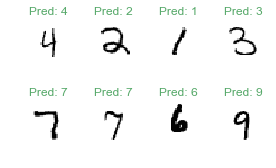

In [31]:
# display normal images
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    break

preds = model(data)
plot_images(data, target, preds, 2, 4)

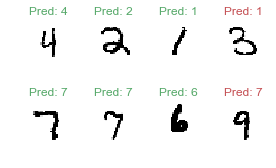

In [32]:
# Display images perturbed with FGSM
perturbed = fgsm(model, data, target, EPSILON)
pert_preds = model(perturbed)
plot_images(perturbed, target, pert_preds, 2, 4)

# How big should $$\epsilon$$ be?

<br>

- the size of $$\epsilon$$ is surprising, with only 0.01 for some samples we can generate adversarial examples that get misclassified


<img src="./figures/part3/attack_ex.png" alt="drawing" class="centered" width="600"/>

# Making several steps towards increasing the loss function

<br>

- in order to create better perturbations, we can apply the same procedure iteratively, trying to maximize the loss:

<div class="centered">
    $$ x' = \prod_{n} (x' + \epsilon * sign( \nabla(J (x, y, \theta) )  $$    
</div>    

<div class="centered">
    $$ \max_{\eta \leq \epsilon}. (J(\theta, x+\eta, y)) $$
</div>    

- thus approximating the space around an input*:

<img src="./figures/part3/normball.png" alt="drawing" class="centered" width="400"/>

<small>
*remember this space is high dimensional 
</small>


- this attack will be described in details during the practical assignments


In [33]:
#  Logic for generating the attack descrribed above
def pgd(nb_iter, data, target, eps, eps_iter, model, delta_init=None):
    if delta_init is not None:
        delta = delta_init
    else:
        delta = torch.zeros_like(data)

    delta.requires_grad_()
    for _ in range(nb_iter):
        output = model(data+delta)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        grad_sign = delta.grad.data.sign()
        delta.data = delta.data + batch_multiply(eps_iter, grad_sign)
        delta.data = batch_clamp(eps, delta.data)
        delta.data = torch.clamp(data.data + delta.data, 0, 1
                                 ) - data.data
        delta.grad.data.zero_()
    data = torch.clamp(data + delta, 0, 1)
    return data

In [34]:
# Logic for testing the model trained above using PGD
def test_pgd(model, device, test_loader, epsilon, nb_iter, eps_iter):
    model.eval()
    corect = 0
    for data, target in test_loader:
        adv = pgd(nb_iter, data, target, epsilon,
                  eps_iter, model)
        output = model(adv)
        pred = output.argmax(dim=1, keepdim=True)
        corect += pred.eq(target.view_as(pred)).sum().item()
    print("Test PGD accuracy {} ({}/{})".format(corect/len(test_loader.dataset), 
                                                corect, 
                                                len(test_loader.dataset)))
    
# test the model trained earlier with PGD
# PGD Attack parameters
NB_ITER = 8
EPS_ITER = 0.01

# run evaluation
model = load_model(SAVE_PATH, device)
_, test_loader = get_data()
test_pgd(model, device, test_loader, EPSILON, NB_ITER, EPS_ITER)    

Test PGD accuracy 0.5722 (5722/10000)


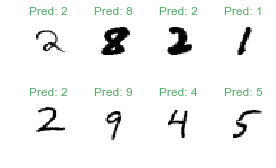

In [35]:
# Display normal images
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    break

preds = model(data)
plot_images(data, target, preds, 2, 4)

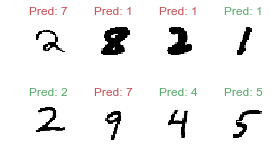

In [36]:
# display PGD perturbed images
perturbed = pgd(NB_ITER,data, target, EPSILON, EPS_ITER, model)
pert_preds = model(perturbed)
plot_images(perturbed, target, pert_preds, 2, 4)

# We can further use other tricks to improve the attacks

For example:

- use momentum
$$ g_{t+1} = \mu * g_t + \frac{\nabla J(\theta, x, y)}{\| \nabla J(x, y) \|_1} $$
<br>
$$x'_{t+1} = x'_{t} + \epsilon * sign(g_{t+1}) $$

- start from a random neighborhood of the initial input
$$ x' = x_{rand} + (\epsilon - \alpha) * sign(\nabla J(\theta, x_{rand}, y)) $$
<br>
$$ x_{rand} = x + \alpha * sign( \mathcal{N} (\mathbb{0}^d, \mathbb{I}^d) ) $$

etc.

- for a detailed overview of possible attacks click [here](https://arxiv.org/abs/1810.01185)

# Other ways to create adversarial examples - learn generate them

- generative models learn a probability distribution and can be used to sample new data from that proability distribution

<br>

- we can train a model to generate a perturbation:

<img src="./figures/part3/gan_adv_1.png" alt="drawing" class="centered" width="600"/>

- or to convert an image:

<img src="./figures/part3/gan_adv_2.png" alt="drawing" class="centered" width="600"/>

# Black-box attacks

- Train substitute models - by generating a dataset and labeling it with the model under attack

- Generate an adversarial example for an ensemble of models -


- Estimate the loss landscape by generating several queries -


- Use genetic algorithms to generate perturbations

# Universal perturbations

- it is possible to generate an image independent perturbation

- for example using the Deep Fool attack for different images and targets and summing the perturbations

<br>


<table class="centered">
<tr>
<td><img src='./figures/part3/universal_2.png'></td>
<td><img src='./figures/part3/universal.png'></td>
</tr></table>

# Adversarial examples generated for a method can transfer to other ML methods

<img src="./figures/part3/transferability.png" alt="drawing" class="centered" width="600"/>

# Transferability across DNN architectures

<img src="./figures/part3/transfer_ITERFGSM_eps_03.png" alt="drawing" class="centered" width="600"/>

- untargeted adversarial examples transfer well 
- targeted adversarial examples do not transfer very well, especially between different DNN architectures


# Hypotheses on the existence of adversarial examples

<br> 
- lie in pockets of the manifold
- are sampled from a different distribution (not i.i.d)
- are expected because the samples used for training are insufficient
- are expected because of the complicated geometry of the decision boundaries


<br> 


<table class="centered">
    <tr><td> Pockets of the manifold </td> <td> Ideal decision boundaries</td> <td> What we get after training (?) </td>
<tr>
<td><img src='./figures/part3/pockets.png'></td>
<td><img src='./figures/part3/decision_1.png'></td>
<td><img src='./figures/part3/decision_2.jpg'></td>
</tr></table>

# Adversarial Defenses

<br>

Types of defenses:

- Guards - add a pre-processing step in which the risk for adversarial examples is eliminated or reduced
    - detection
    - apply input transformations
- Defense by design - strengthen the model
    - <div class="grey">adversarial training</div>
    - custom regularization
    - <div class="grey">using formal methods</div>

# Adversarial training

<br>

- add adversarial examples to the training data

- nudge the model to learn a robust decision boundary


<table class="centered" width="800">
    <tr><td> Decision boundaries without adv. training </td> <td> Decision boundaries robust classiefiers</td>
<tr>
<td><img src='./figures/part3/adversarial_decision_boundary_3.png'></td>
<td><img src='./figures/part3/adversarial_decision_boundary_2.png'></td>
</tr></table>

# Adversarial training

<br>

- generate adverarial examples using a fast method, e.g. FGSM:

<div class="centered">
$$ \eta = \epsilon* sign ( \nabla (J(x, y, \theta))) $$
</div>

- add them to trainig, balancing the amount of adversarial and normal inputs

<div class="centered">
$$ \tilde{J}(\cdot) =    \alpha J(\theta, x, y) +  (1-\alpha)  J(\theta, x', y) $$
</div>

where $$\alpha$$ controls the contribution of adversarial examples

<div class="grey"> Disasdvantages:</div>

- this simple method too generate attacks does not approximate all possible perturbations given $$\epsilon$$

- an attacker can choose different directions and still find a successful attack

# Adversarial training on the worst perturbation

<br>

- generating examples:

<div class="centered">
    $$ \min. \max_{\eta \leq \epsilon}. (J(\theta, x+\eta, y)) $$
</div>

- solving the inner maximization problem can be done using the iterative procedure introduced earlier

- solving the outter minimization problem can be done using back-propagation 

- protection against the worst possible example should protect for any adversary in the $$\epsilon$$ norm-ball


<table class="centered" width="800">
    <tr><td> Worst case perturbations </td> <td> Decision boundaries robust classiefiers</td>
<tr>
<td><img src="./figures/part3/normball.png" alt="drawing" class="centered"/></td>
<td><img src='./figures/part3/adversarial_decision_boundary_2.png'></td>
</tr></table>

In [37]:
EPOCHS = 1
# PGD Attack parameters
NB_ITER = 1
EPS_ITER = 0.01

# Logic for training a model on the worst case perturbation
def train_pgd(model, device, train_loader, optimizer, criterion, epsilon, nb_iter, eps_iter):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        datax = pgd(nb_iter, data, target, epsilon,
                    eps_iter, model)
        data, target = datax.to(device), target.to(device)
        optimizer.zero_grad()
        # get loss
        output = model(data)
        loss = criterion(output, target)
        # backpropagate
        loss.backward()
        optimizer.step()

train_loader, test_loader = get_data()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for i in range(EPOCHS):
    train_pgd(model, device, train_loader, optimizer, criterion, EPSILON, NB_ITER, EPS_ITER)
    test_pgd(model, device, test_loader, EPSILON, NB_ITER, EPS_ITER)
    test_epoch(model, test_loader)        

Test PGD accuracy 0.9655 (9655/10000)
Test average acccuracy 0.6428 (6428/10000)


- typically the model overfits on adv. examples
- there is a trade off between robustness and accuracy

# Efficacy of adversarial training

<br>

- it is still one of the best defenses

<div class="grey">with some perks:</div>

- generating adversarial examples that can approximate the norm-ball around an input requires several back and forth passes, which increase training time (for 10 iterations training time increases 10x)

- the model overfits on training examples and does not generalize well


<div class="grey">some solutions to decrease training time exist:</div>

- free adversarial training
- you only propagate once

# Practical Assignment

- for those who can not run the notebook from Github, a notebook can be found at:

<div class="centered">
    https://tinyurl.com/uqtu3xx

</div>


- long url: https://colab.research.google.com/drive/1cmZSIk0LhL25zuamGsDg3UY6KKlsiLNO

# Conclusions and future directions

- There is no universally accepted conjecture on the existence of adversarial examples (although the assumptions seem give a good indication)

- Adversarial examples are relevant to security only when an application provides some security functionality

- There is a big misconception that adversarial examples a threat to safety (although safety requires unintentional perturbations, not intentional)